In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd /content/Hierarchical-Localization
!pip install -e .
!pip install --upgrade --quiet plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 56.3 MB/s eta 0:00:00
  Running setup.py develop for hloc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 96.7 MB/s eta 0:00:00


In [2]:
# back to content dir (home)
%cd ..

/content


In [3]:
# Get image datasets

!git clone https://github.com/KOE-Wayfind/koe-datasets

Cloning into 'koe-datasets'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (644/644), done.
remote: Compressing objects: 100% (627/627), done.
remote: Total 689 (delta 21), reused 638 (delta 15), pack-reused 45
Receiving objects: 100% (689/689), 202.99 MiB | 31.50 MiB/s, done.
Resolving deltas: 100% (21/21), done.


# Setup
Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [4]:
images = Path('koe-datasets/new')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

# feature_conf = extract_features.confs['superpoint_aachen'] # for outdoor
feature_conf = extract_features.confs['superpoint_inloc'] # for indoor
matcher_conf = match_features.confs['superglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of KOE Building.

['rgb/enginius-office/enginius-office_4.jpg', 'rgb/enginius-office/enginius-office_11.jpg', 'rgb/enginius-office/enginius-office_22.jpg', 'rgb/enginius-office/enginius-office_19.jpg', 'rgb/enginius-office/enginius-office_6.jpg', 'rgb/enginius-office/enginius-office_15.jpg', 'rgb/enginius-office/enginius-office_12.jpg', 'rgb/enginius-office/enginius-office_21.jpg', 'rgb/enginius-office/enginius-office_3.jpg', 'rgb/enginius-office/enginius-office_18.jpg', 'rgb/oscent/oscent_13.jpg', 'rgb/oscent/oscent_24.jpg', 'rgb/oscent/oscent_18.jpg', 'rgb/oscent/oscent_12.jpg', 'rgb/oscent/oscent_5.jpg', 'rgb/oscent/oscent_7.jpg', 'rgb/oscent/oscent_2.jpg', 'rgb/oscent/oscent_10.jpg', 'rgb/oscent/oscent_26.jpg', 'rgb/oscent/oscent_8.jpg', 'rgb/oddai/oddai_13.jpg', 'rgb/oddai/oddai_20.jpg', 'rgb/oddai/oddai_14.jpg', 'rgb/oddai/oddai_3.jpg', 'rgb/oddai/oddai_11.jpg', 'rgb/oddai/oddai_7.jpg', 'rgb/oddai/oddai_6.jpg', 'rgb/oddai/oddai_8.jpg', 'rgb/oddai/oddai_18.jpg', 'rgb/oddai/oddai_12.jpg', 'rgb/Main-

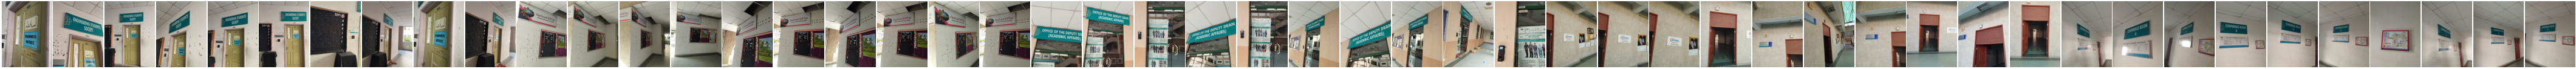

In [5]:
import random

def get_images(folder_path, num_images):
    images = list(folder_path.glob('*.jpg'))
    selected_images = random.sample(images, min(num_images, len(images)))
    return selected_images

# folder_path = Path.joinpath(images, 'new')

# Choose between color and grayscale
color_mode = "color"

# Choose the number of images from each folder
num_images = 10

exclude_dirs = ["conference-b"]

references = []
if color_mode == 'color':
    folder = images / 'rgb/'
else:
    folder = images / 'gray/'

# Get the selected images from each folder
for sub_folder in folder.iterdir():
    if sub_folder.is_dir() and sub_folder.name not in exclude_dirs:
        selected_images = get_images(sub_folder, num_images)
        references.extend([str(p.relative_to(images)) for p in selected_images])

print(references)
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)


Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [6]:
from time import monotonic
start_time = monotonic()

extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/06/11 21:20:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/50 [00:00<?, ?it/s]

[2023/06/11 21:20:31 hloc INFO] Finished exporting features.
[2023/06/11 21:20:31 hloc INFO] Found 1225 pairs.
[2023/06/11 21:20:31 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1225 [00:00<?, ?it/s]

[2023/06/11 21:21:53 hloc INFO] Finished exporting matches.


The we run incremental Structure-from-Motion and display the reconstructed 3D model.

In [7]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
print(f"Reconstruction time {monotonic() - start_time} seconds")

# fig = viz_3d.init_figure()
# viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
# fig.show()

[2023/06/11 21:21:53 hloc INFO] Creating an empty database...
[2023/06/11 21:21:53 hloc INFO] Importing images into the database...
[2023/06/11 21:21:53 hloc INFO] Importing features into the database...


  0%|          | 0/50 [00:00<?, ?it/s]

[2023/06/11 21:21:53 hloc INFO] Importing matches into the database...


  0%|          | 0/1225 [00:00<?, ?it/s]

[2023/06/11 21:21:55 hloc INFO] Performing geometric verification of the matches...
[2023/06/11 21:22:19 hloc INFO] Running 3D reconstruction...
[2023/06/11 21:22:34 hloc INFO] Reconstructed 2 model(s).
[2023/06/11 21:22:34 hloc INFO] Largest model is #1 with 29 images.
[2023/06/11 21:22:34 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 29
	num_cameras = 1
	num_points3D = 1380
	num_observations = 5377
	mean_track_length = 3.89638
	mean_observations_per_image = 185.414
	mean_reprojection_error = 0.967767
	num_input_images = 50


Reconstruction time 138.230530483 seconds


We also visualize which keypoints were triangulated into the 3D model.

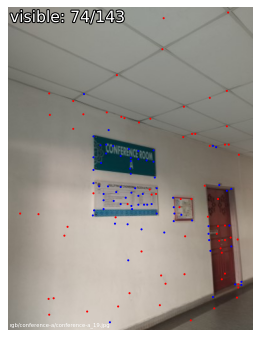

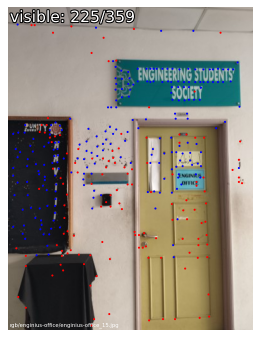

In [8]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

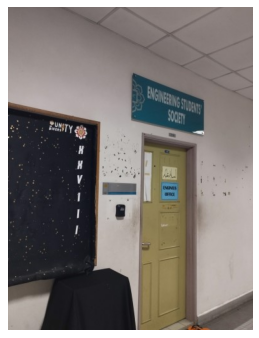

In [14]:
query = 'validation-night-rgb/enginius-office/enginius-office_8.jpg'

plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [15]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/06/11 21:28:00 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/06/11 21:28:00 hloc INFO] Finished exporting features.
[2023/06/11 21:28:00 hloc INFO] Found 29 pairs.
[2023/06/11 21:28:00 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/29 [00:00<?, ?it/s]

[2023/06/11 21:28:02 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 296/601 inlier correspondences.
Match percentage 49.25124792013311


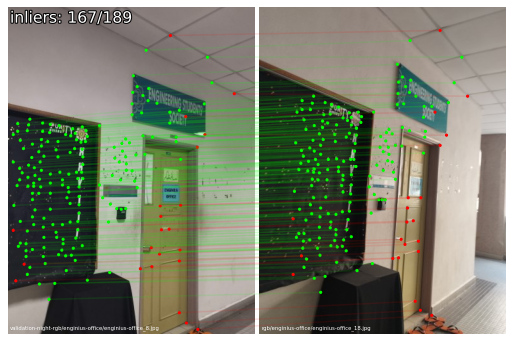

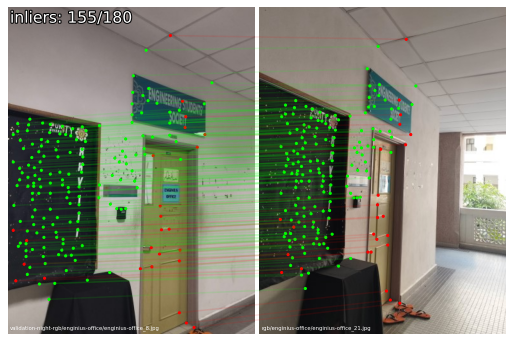

In [16]:
import pycolmap
import numpy as np
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
percent_match = (ret["num_inliers"]/len(ret["inliers"])) * 100
print(f'Match percentage {percent_match}')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [17]:
# pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
# viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
# fig.show()